In [9]:
import pandas as pd
import numpy as np
import os
import sys
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
import scipy as sp

import plotly.graph_objects as go
import plotly.io as pio

pd.set_option('display.max_rows',999)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

from st_utils import correct_tissue_names
from st_utils import name_parser, get_gene_type
from st_utils import log2_fold_change
from st_utils import correct_platform_panel
from constants import matching_cores, CB_COLORS_5
from constants import SAMPLES, sample_color
from constants import xenium_breast_htma_matching_cores
from constants import merscope_breast_htma_matching_cores
from constants import cosmx_multitissue_htma_matching_cores, CORRECT_PLATFORM_PANEL

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

wd = os.getcwd()
print (f'working directory: {wd}')


def hc_linear_test(df, col1, col2):
    """
    Performs the Harvey-Collier test for linearity on two columns of a DataFrame.

    Parameters
    ----------
    df : pd.DataFrame
        The DataFrame containing the data.
    col1 : str
        The name of the independent variable column.
    col2 : str
        The name of the dependent variable column.

    Returns
    -------
    float
        The Harvey-Collier test statistic.
    float
        The p-value of the Harvey-Collier test.
    """
    # Extract the independent and dependent variables
    X = df[col1]
    y = df[col2]
    
    # Add a constant to the independent variable for the intercept
    X = sm.add_constant(X)
    
    # Fit a linear regression model
    model = sm.OLS(y, X).fit()
    
    # Perform the Harvey-Collier test
    hc_test = sm.stats.linear_harvey_collier(model)
    
    # Return the test statistic and p-value
    return hc_test.statistic, hc_test.pvalue


convert_tma_name_dict = {
    'HTMA':'tTMA1',
    'TUMOR2':'tTMA2',
    'NORMAL':'nTMA',
    'normal':'nTMA',
    'tTMA1':'tTMA1'
    }

def gene_by_gene_plot(df_pair, x_col, y_col, marker_color, x_label, y_label, tmas, year, figure_name, cus_anno='',label_genes=[],plot_residuals=False, fontsize=20, marker_size=7, markeredgewidth=1):
    x = df_pair[x_col]
    y = df_pair[y_col]

    df_pair['gene_type'] = df_pair['gene'].apply(lambda x:get_gene_type(x))
    df_pair = df_pair.loc[df_pair['gene_type']=='gene']

    r, p = sp.stats.spearmanr(
    np.log10(x.replace(0, np.nan)).dropna(),
    np.log10(y.replace(0, np.nan)).dropna(),
    )

    p_text = '< 0.0001' if p < 0.0001 else f"= {round(p, 7)}"
    m_fold = round(df_pair['fold'].median(), 2)

    if m_fold < 0.05:
        m_fold = round(m_fold, 2)
    else:
        m_fold = round(m_fold, 1)

    # Scatter plot
    plt.figure(figsize=(6, 6))

    # Points
    plt.loglog(
        x,
        y,
        linestyle='none',  # Ensure no connecting line between points
        marker='o',
        markersize=marker_size,
        markerfacecolor='none',
        markeredgewidth=markeredgewidth,
        markeredgecolor=marker_color,
    )

    # Fitting the line in log-log space
    log_x = np.log10(x)
    log_y = np.log10(y)
    coefficients = np.polyfit(log_x, log_y, 1)
    
    polynomial = np.poly1d(coefficients)
    x_poly = np.logspace(np.log10(min(x)), np.log10(max(x)), 100)
    log_y_poly = polynomial(np.log10(x_poly))
    y_poly = 10 ** log_y_poly

    # Calculate residuals and standard error
    log_y_fitted = polynomial(log_x)
    residuals = log_y - log_y_fitted
    std_err = np.sqrt(np.sum(residuals**2) / (len(log_y) - 2))
    residuals_poly = [10 ** abs(x) for x in residuals]
    y_fitted = 10 ** log_y_fitted
    residuals_poly = y - y_fitted
    std_err_linear = np.sqrt(np.sum(residuals_poly**2) / (len(y) - 2))

    # Compute the 95% confidence interval in linear space
    t_value = 1.96  # For 95% confidence interval
    y_upper = y_poly + t_value * std_err_linear
    y_lower = y_poly - t_value * std_err_linear


    # Plot the fitted line
    plt.plot(x_poly, y_poly, label='Fitted Line', color='red')

    # Plot the confidence interval
    plt.fill_between(x_poly, y_lower, y_upper, color=marker_color, alpha=0.1, label='95% CI')

    # Reference line y=x
    min_all = np.min([x.min(), y.min()])
    max_all = np.max([x.max(), y.max()])
    xy_line_lim = [min_all, max_all]
    plt.plot(xy_line_lim, xy_line_lim, color='#D3D3D3', linestyle='-.', alpha=0.75)

    annotation_text = f"Spearman R = {round(r,2)}\np value {p_text}\nMedian fold = {m_fold}"
    annotation_text = annotation_text + cus_anno
    
    plt.text(min_all*1.01, max_all*1.2, annotation_text, fontsize=fontsize-2, verticalalignment='top')     

    plt.xlabel(x_label, fontsize=fontsize)
    plt.ylabel(y_label, fontsize=fontsize)

    # Label each marker with gene name
    for idx, row in df_pair.iterrows():
        gene = row['gene']
        if gene in label_genes:
            gene_x = row[x_col]
            gene_y = row[y_col]
            if not np.isnan(gene_x) and not np.isnan(gene_y):
                plt.annotate(gene, (gene_x, gene_y), textcoords="offset points", xytext=(5,-3), ha='left', fontsize=8)

    # Save and show the plot
    plt.savefig(f"{figure_name}.png", bbox_inches='tight', transparent=True)
    plt.savefig(f"{figure_name}.eps", bbox_inches='tight', transparent=True)
    plt.show()


    # Residual plot
    if plot_residuals:

        plt.figure(figsize=(6, 6))
        sns.regplot(x=x, y=[abs(x) for x in residuals_poly], fit_reg=False, color=marker_color, scatter_kws={'facecolors': 'none', 'linewidths': 2, 's': 55})
        plt.axhline(0, color='red', linestyle='--', lw=2)

        if tmas == ['tTMA1']:
            plt.xlabel(f"Gene exp. of {x_col} vs. (23)", fontsize=fontsize)
        else:
            plt.xlabel(f"Gene exp. of {x_col} vs.\n{y_col} from {convert_tma_name_dict[tmas[0]]}({year[-2:]})", fontsize=fontsize)

        plt.ylabel('Residuals', fontsize=fontsize)

        plt.title('')
        plt.tight_layout()

        plt.xscale('log')
        plt.yscale('log')

        plt.savefig(f"{wd}/figures/residuals/{year}_{'_and_'.join(tmas)}_{x_col}_vs_{y_col}.png", bbox_inches='tight', transparent=True)  
        plt.show()

    return r, p, residuals_poly



working directory: /Users/whuan/dev/ist_benchmarking


In [10]:
by_sample = False

year = '2024'

samples = [x for x in SAMPLES]
if year == '2024':
    samples = [x for x in SAMPLES if '2024' in x]
elif year == '2023':
    samples = [x for x in SAMPLES if '2024' not in x]
else:
    samples = [x for x in SAMPLES]
print (samples)


['2024_xenium_breast_htma', '2024_xenium_breast_tumor2', '2024_merscope_breast_htma', '2024_merscope_breast_tumor2', '2024_cosmx_multitissue_htma', '2024_cosmx_multitissue_tumor2']


# Load data

In [11]:
metric = f'count'
df_m = pd.DataFrame()
for sample in samples:
    print (f'sample: {sample}')
    df_t = pd.read_csv(f'{wd}/data/gene_level_csv/gene_level_csv_{sample}.csv')
    df_t = correct_tissue_names(sample, df_t)
    # Reindex normal tissue cores 
    df_t['core'] += (300 if 'tumor2' in sample else 0) + (200 if 'normal' in sample else 0)
    # Consolidate tissue type
    # df_t = df_t.replace({'LN':'Lymph node','MARKER':'Marker'}) if 'htma' in sample else df_t
    df_t['sample'] = sample
    df_m = pd.concat([df_m,df_t])
    
df_m = df_m.loc[df_m['core'].isin(matching_cores)]
df_m['platform'] = df_m['sample'].apply(lambda x: name_parser(x)['platform'].upper())
df_m['panel'] = df_m['sample'].apply(lambda x: name_parser(x)['panel'])
df_m['tma'] = df_m['sample'].apply(lambda x: name_parser(x)['tma'].upper())

df_plot = df_m.copy()
df_plot = df_plot.drop(['sample'], axis=1)
df_plot = df_plot.groupby(['platform','panel','gene']).agg({metric: 'sum'}).reset_index()
df_plot['platform_panel'] = df_plot.apply(lambda row: f"{row['platform']},{row['panel']}", axis=1)
df_plot = df_plot.pivot(index = 'gene', columns = 'platform_panel', values = 'count').reset_index()

if by_sample:
    df_plot = df_m.copy()
    df_plot = df_plot.groupby(['sample','gene']).agg({metric: 'sum'}).reset_index()
    df_plot = df_plot.pivot(index = 'gene', columns = 'sample', values = 'count').reset_index()

sample: 2024_xenium_breast_htma
sample: 2024_xenium_breast_tumor2
sample: 2024_merscope_breast_htma
sample: 2024_merscope_breast_tumor2
sample: 2024_cosmx_multitissue_htma
sample: 2024_cosmx_multitissue_tumor2


# Plot gene-by-gene plot between Platform-panels by TMA

Xenium,Breast panel CosMx,1k panel ['HTMA']


TypeError: argument of type 'bool' is not iterable

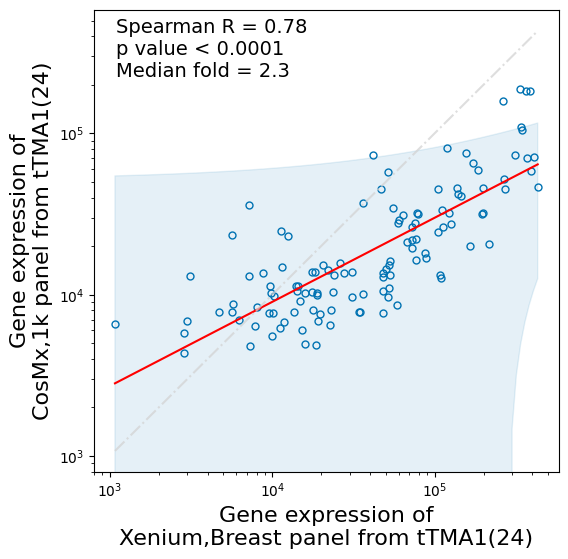

In [12]:
if not os.path.exists(f'{wd}/figures/Fig_2_Technical_Performance'):
    os.makedirs(f'{wd}/figures/Fig_2_Technical_Performance')

fontsize=16

if year =='2023':

    for tmas in [['HTMA'], ['NORMAL']]:
        df_plot = df_m.loc[df_m['tma'].isin(tmas)]
        df_plot = df_plot.drop(['sample'], axis=1)
        df_plot = df_plot.groupby(['platform','panel','gene']).agg({metric: 'sum'}).reset_index()
        df_plot['platform_panel'] = df_plot.apply(lambda row: f"{row['platform']}_{row['panel']}", axis=1)
        df_plot = df_plot.pivot(index = 'gene', columns = 'platform_panel', values = 'count').reset_index()
        df_plot.columns = ['gene',
                    'CosMx,1k panel',
                    'MERSCOPE,Breast panel', 
                    'MERSCOPE,Lung panel',
                    'Xenium,Breast panel',
                    'Xenium,Lung panel',
                    'Xenium,Multi-tissue panel']

        for count, platform_panel_pair in enumerate(
            [('Xenium,Breast panel','CosMx,1k panel'),
            ('Xenium,Lung panel','CosMx,1k panel'),
            ('MERSCOPE,Breast panel','CosMx,1k panel',),
            ('MERSCOPE,Lung panel','CosMx,1k panel'),
            ('Xenium,Breast panel','MERSCOPE,Breast panel'),
            ('Xenium,Lung panel','MERSCOPE,Lung panel'),
            ('Xenium,Multi-tissue panel','CosMx,1k panel')
                                    ]):
            color_index = int(np.floor(count/2+1))

            x_col = platform_panel_pair[0]
            y_col = platform_panel_pair[1]

            print(x_col, y_col, tmas)


            df_pair = df_plot[['gene', x_col, y_col]]
            df_pair = df_pair.reset_index(drop=True).dropna()
            df_pair['fold'] = df_pair.apply(lambda row: row[x_col] / row[y_col], axis=1)


            if tmas == ['tTMA1']:
                x_label = f"Gene expression of\n{x_col}"
                y_label = f"Gene expression of\n{y_col}"
            else:
                x_label = f"Gene expression of\n{x_col} from {convert_tma_name_dict[tmas[0]]}({year[-2:]})"
                y_label = f"Gene expression of\n{y_col} from {convert_tma_name_dict[tmas[0]]}({year[-2:]})"

            r, p, residuals = gene_by_gene_plot(
                df_pair,
                x_col,
                y_col,
                list(CB_COLORS_5.values())[color_index],
                x_label,
                y_label,
                tmas,
                year,
                figure_name=f"{wd}/figures/Fig_2_Technical_Performance/Main_Fig_2_ABC_{year}_{x_col}_vs_{y_col}_from_{'_and_'.join(tmas)}",
                label_genes=False,
                fontsize=fontsize,
                marker_size=5,
            )


            # r, p, residuals = gene_by_gene_plot(
            #     df_pair,
            #     x_col,
            #     y_col,
            #     list(CB_COLORS_5.values())[color_index],
            #     x_label,
            #     y_label,
            #     tmas,
            #     year,
            #     figure_name=f"{wd}/figures/Fig_2_Technical_Performance/Main_Fig_2_ABC_{year}_{x_col}_vs_{y_col}_from_{'_and_'.join(tmas)}_with_gene_label",
            #     label_genes=[],
            #     fontsize=fontsize,
            #     marker_size=5,
            # )

elif year =='2024':

    for tmas in [['HTMA'], ['TUMOR2']]:
        df_plot = df_m.loc[df_m['tma'].isin(tmas)]
        df_plot = df_plot.drop(['sample'], axis=1)
        df_plot = df_plot.groupby(['platform','panel','gene']).agg({metric: 'sum'}).reset_index()
        df_plot['platform_panel'] = df_plot.apply(lambda row: f"{row['platform']}_{row['panel']}", axis=1)
        df_plot = df_plot.pivot(index = 'gene', columns = 'platform_panel', values = 'count').reset_index()
        df_plot.columns = ['gene',
                    'CosMx,1k panel',
                    'MERSCOPE,Breast panel', 
                    'Xenium,Breast panel']

        for count, platform_panel_pair in enumerate([
            ('Xenium,Breast panel','CosMx,1k panel'),
            ('CosMx,1k panel','MERSCOPE,Breast panel'),
            ('Xenium,Breast panel','MERSCOPE,Breast panel'),
            ]):

            color_index = count + 1
            marker_color=list(CB_COLORS_5.values())[color_index]
            
            x_col = platform_panel_pair[0]
            y_col = platform_panel_pair[1]

            print(x_col, y_col, tmas)

            df_pair = df_plot[['gene', x_col, y_col]]
            df_pair = df_pair.reset_index(drop=True).dropna()
            df_pair['fold'] = df_pair.apply(lambda row: row[x_col] / row[y_col], axis=1)


            if tmas == ['tTMA1']:
                x_label = f"Gene expression of\n{x_col}"
                y_label = f"Gene expression of\n{y_col}"
            else:
                x_label = f"Gene expression of\n{x_col} from {convert_tma_name_dict[tmas[0]]}({year[-2:]})"
                y_label = f"Gene expression of\n{y_col} from {convert_tma_name_dict[tmas[0]]}({year[-2:]})"

            r, p, residuals = gene_by_gene_plot(
                df_pair,
                x_col,
                y_col,
                marker_color,
                x_label,
                y_label,
                tmas,
                year,
                figure_name=f"{wd}/figures/Fig_2_Technical_Performance/Main_Fig_2_ABC_{year}_{x_col}_vs_{y_col}_from_{'_and_'.join(tmas)}",
                label_genes=False,
                fontsize=fontsize,
                marker_size=5,
            )

            # r, p, residuals = gene_by_gene_plot(
            #     df_pair,
            #     x_col,
            #     y_col,
            #     marker_color,
            #     x_label,
            #     y_label,
            #     tmas,
            #     year,
            #     figure_name=f"{wd}/figures/Fig_2_Technical_Performance/Main_Fig_2_ABC_{year}_{x_col}_vs_{y_col}_from_{'_and_'.join(tmas)}_with_gene_label",
            #     label_genes=[],
            #     fontsize=fontsize,
            #     marker_size=5,
            # )

# Core to core reproducibility (2023 method)

105 106
sample: xenium_breast_htma


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


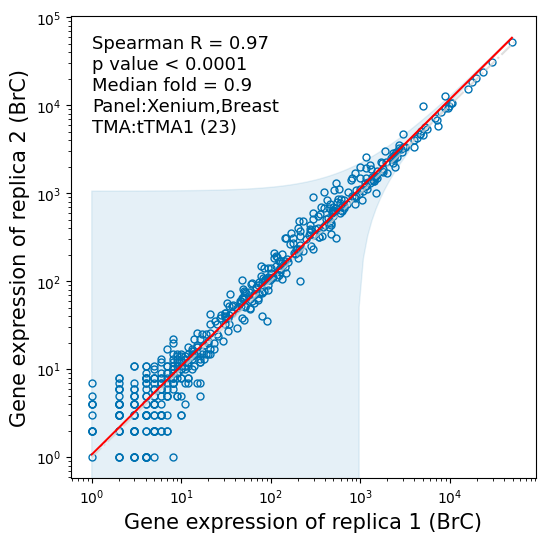

sample: xenium_panhuman_htma


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


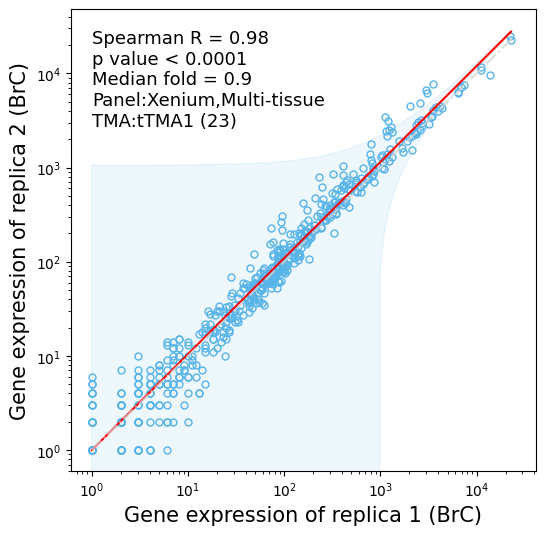

sample: xenium_lung_htma


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


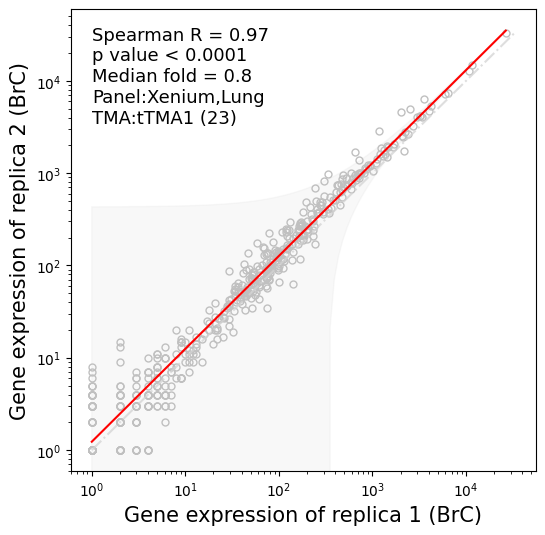

sample: merscope_breast_htma


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


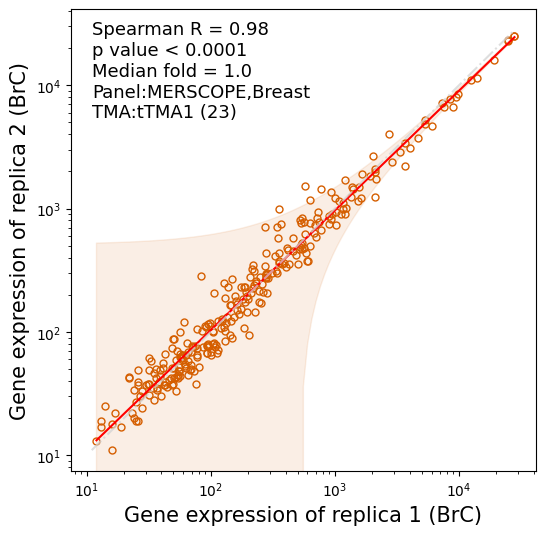

sample: merscope_lung_htma


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


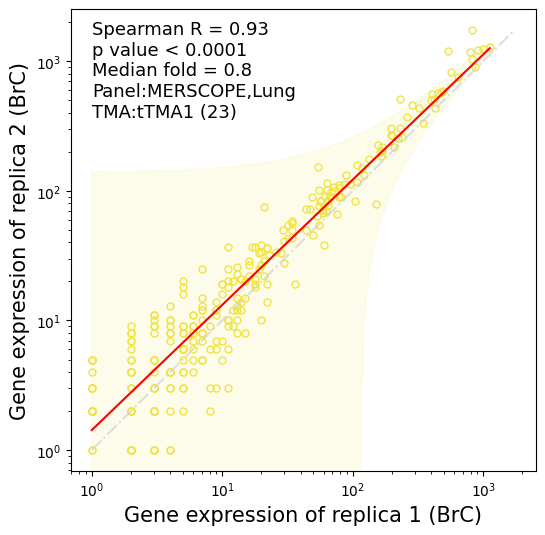

sample: cosmx_multitissue_htma


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


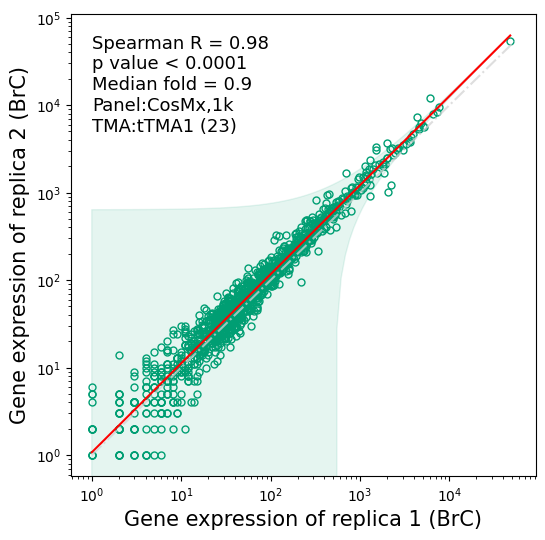

In [5]:
if not os.path.exists(f'{wd}/figures/Fig_1'):
    os.makedirs(f'{wd}/figures/Fig_1')
Log_transform_method = 'log10'
rs = []
sams = []
core_ps = []
fontsize = 15

for core_pair in [[105, 106]]:
    core_1 = core_pair[0]
    core_2 = core_pair[1]
    print (core_1, core_2)
    
    metric = f'count'
    df_m = pd.DataFrame()
    # for sample in ['xenium_lung_htma','merscope_breast_htma','cosmx_multitissue_htma']:
    for sample in SAMPLES[::2]:
        if '2024'  not in sample:

            print (f'sample: {sample}')
            df_t = pd.read_csv(f'{wd}/data/gene_level_csv/gene_level_csv_{sample}.csv')
            df_t = correct_tissue_names(sample, df_t)
            # Reindex normal tissue cores 
            df_t.core = df_t.core + 200 if 'normal' in sample else df_t.core
            platform_panel = CORRECT_PLATFORM_PANEL['_'.join(sample.split('_')[:2])]
            df_core_1 = df_t.loc[df_t['core']==core_1][['gene','tissue_type','count']]
            df_core_1 = df_core_1.rename(columns={'count':f'Core_{core_1}'})
            df_core_2 = df_t.loc[df_t['core']==core_2][['gene','count']]
            df_core_2 = df_core_2.rename(columns={'count':f'Core_{core_2}'})
            df_core_pair = pd.merge(df_core_1, df_core_2, on='gene', how='inner')

            x_col = f'Core_{core_1}'
            y_col = f'Core_{core_2}'

            df_pair = df_core_pair[['gene', x_col, y_col]]
            df_pair = df_pair.reset_index(drop=True).dropna()
            df_pair['fold'] = df_pair.apply(lambda row: row[x_col] / row[y_col], axis=1)

            x_label = f'Gene expression of replica 1 (BrC)'
            y_label = f'Gene expression of replica 2 (BrC)'
            figure_name = f'{wd}/figures/Fig_1/supp_1_Core_{core_1}_vs_Core_{core_2}_reproducibility_{platform_panel}'
            cus_anno=f"\nPanel:{platform_panel}\nTMA:tTMA1 (23)"

            r, p, residuals = gene_by_gene_plot(
                df_pair,
                x_col,
                y_col,
                sample_color[platform_panel],
                x_label,
                y_label,
                tmas,
                year,
                figure_name=figure_name,
                cus_anno=cus_anno,
                fontsize=fontsize,
                label_genes=[],
                marker_size=5,
                markeredgewidth=1
            )

            # r, p, residuals = gene_by_gene_plot(
            #     df_pair,
            #     x_col,
            #     y_col,
            #     sample_color[platform_panel],
            #     x_label,
            #     y_label,
            #     tmas,
            #     year,
            #     figure_name=f'{wd}/figures/Fig_1/supp_1_Core_{core_1}_vs_Core_{core_2}_reproducibility_{platform_panel}_with_gene_label',
            #     cus_anno=cus_anno,
            #     fontsize=fontsize,
            #     label_genes=[],
            #     marker_size=5,
            #     markeredgewidth=1
            # )

        rs.append(round(r,3))
        core_ps.append(f'Core {str(core_1).zfill(3)} vs. {str(core_2).zfill(3)}')
        sams.append(sample.upper())


88 89
95 96
105 106
109 110
111 112
115 116
131 132
151 152
156 157
158 159
165 166
168 169


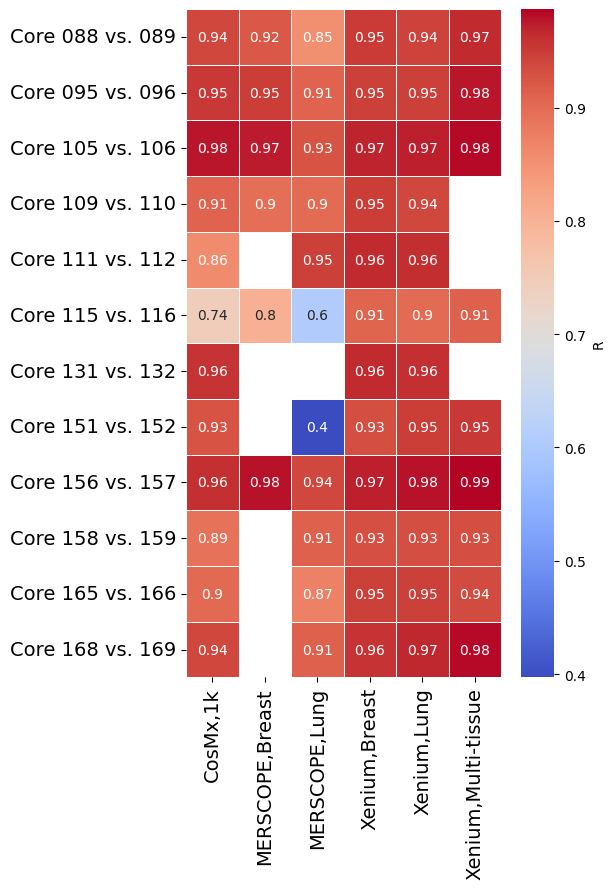

In [6]:
rs = []
sams = []
core_ps = []

for core_pair in [[88, 89],
                [95, 96],
                [105, 106],
                [109, 110],
                [111, 112],
                [115, 116],
                [131, 132],
                [151, 152],
                [156, 157],
                [158, 159],
                [165, 166],
                [168, 169]]:
    core_1 = core_pair[0]
    core_2 = core_pair[1]
    print (core_1, core_2)


    metric = f'count'
    df_m = pd.DataFrame()
    # for sample in ['xenium_lung_htma','merscope_breast_htma','cosmx_multitissue_htma']:
    for sample in SAMPLES[::2]:

        try:
            # print (f'sample: {sample}')
            df_t = pd.read_csv(f'{wd}/data/gene_level_csv/gene_level_csv_{sample}.csv')
            df_t = correct_tissue_names(sample, df_t)
            # Reindex normal tissue cores 
            df_t['core'] += (300 if 'tumor2' in sample else 0) + (200 if 'normal' in sample else 0)
            # Consolidate tissue type

            platform_panel = CORRECT_PLATFORM_PANEL['_'.join(sample.split('_')[:2])]

            df_core_1 = df_t.loc[df_t['core']==core_1][['gene','tissue_type','count']]
            df_core_1 = df_core_1.rename(columns={'count':f'Core_{core_1}'})
            df_core_2 = df_t.loc[df_t['core']==core_2][['gene','count']]
            df_core_2 = df_core_2.rename(columns={'count':f'Core_{core_2}'})
            df_core_pair = pd.merge(df_core_1, df_core_2, on='gene', how='inner')
            df_core_pair['fold'] = df_core_pair.apply(lambda row: round(row[f'Core_{core_1}'] /row[f'Core_{core_2}']), axis=1)
            m_fold = df_core_pair['fold'].median()
            if m_fold < 0.05:
                m_fold = round(m_fold, 2)
            else:
                m_fold = round(m_fold, 1)


            r, p = sp.stats.spearmanr(df_core_pair[f'Core_{core_1}'], df_core_pair[f'Core_{core_2}'])
            p = '< 0.0001' if p < 0.0001 else round(p, 7)
            rs.append(round(r,3))
            core_ps.append(f'Core {str(core_1).zfill(3)} vs. {str(core_2).zfill(3)}')
            sams.append(sample.upper())
        except:
            continue


df = pd.DataFrame({'Sample':sams, 'Core Pair':core_ps, 'Correlation':rs})
df['Platform_Panel'] = df['Sample'].apply(lambda x: f"{x.split('_')[0]}_{x.split('_')[1]}")
df = correct_platform_panel(df, 'Platform_Panel')
df_plot = df.copy()
df_plot = df_plot.sort_values(by=['Core Pair'])
df_plot = df_plot.pivot(index='Platform_Panel', columns='Core Pair', values='Correlation')


# Create the heatmap with annotations
plt.figure(figsize=(6, 9))
g = sns.heatmap(df_plot.T, annot=True, cmap='coolwarm', linewidths=0.5,cbar_kws={'label': 'R'})
cbar = g.collections[0].colorbar
cbar.ax.set_position([0.6, 0.1, 0.1, 0.77]) #
# cbar.ax.set_ylabel(f"{' '.join(metric.split('_')).capitalize()} per cell across tissue types by platform x panel", rotation=270, labelpad=20, fontsize=16)
plt.xlabel('')
plt.ylabel('')

fontsize=14
xlabels = g.get_xticklabels()
g.set_xticklabels(xlabels, fontsize=fontsize, rotation=90, ha="center")

ylabels = g.get_yticklabels()
g.set_yticklabels(ylabels, fontsize=fontsize)

plt.tight_layout()
plt.savefig(f'{wd}/figures/Fig_1/supp_1_heatmap_of_core_reproducibility.png', dpi=250, transparent=True)
plt.savefig(f'{wd}/figures/Fig_1/supp_1_heatmap_of_core_reproducibility.eps', dpi=250, transparent=True)
plt.show()

# Real sample to sample reproducibility

Xenium, Breast panel from tTMA1(24) Xenium, Breast panel from tTMA1(23)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


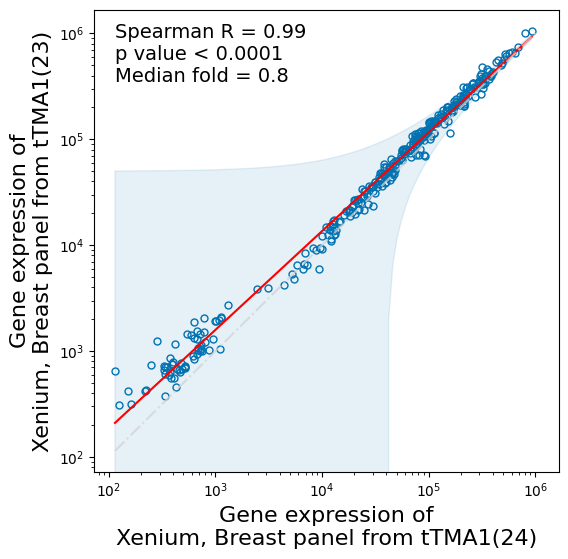

TypeError: argument of type 'bool' is not iterable

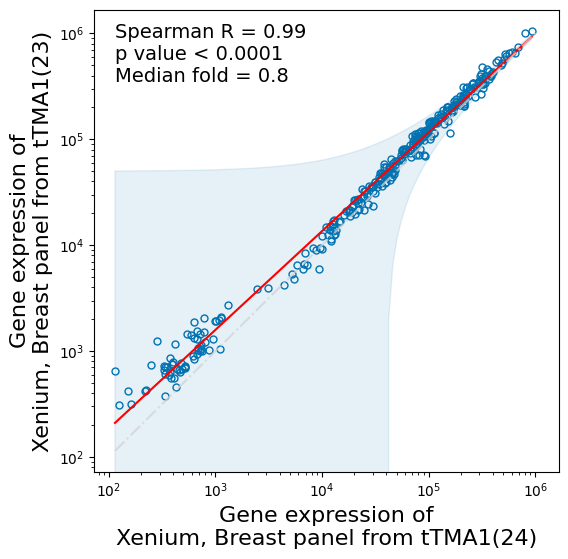

In [ ]:
if not os.path.exists(f'{wd}/figures/Fig_2_Technical_Performance'):
    os.makedirs(f'{wd}/figures/Fig_2_Technical_Performance')

def convert_sample_name(sample_name):
    sample_name = sample_name.replace('xenium_breast', 'Xenium, Breast panel')
    sample_name = sample_name.replace('xenium_lung', 'Xenium, Lung panel')
    sample_name = sample_name.replace('xenium_multitissue', 'Xenium, Multi-tissue panel')
    sample_name = sample_name.replace('cosmx_multitissue', 'CosMx, 1k panel')
    sample_name = sample_name.replace('merscope_breast', 'MERSCOPE, Breast panel')
    sample_name = sample_name.replace('merscope_lung', 'MERSCOPE, Lung panel')
    sample_name = sample_name.replace('_', ' from ')

    return sample_name

metric = f'count'
df_m = pd.DataFrame()
for sample in SAMPLES:
    if 'htma' in sample:
        # print (f'sample: {sample}')
        df_t = pd.read_csv(f'{wd}/data/gene_level_csv/gene_level_csv_{sample}.csv')
        df_t = correct_tissue_names(sample, df_t)
        df_t['core'] += (300 if 'tumor2' in sample else 0) + (200 if 'normal' in sample else 0)
        df_t['sample'] = sample

        matching_cores = xenium_breast_htma_matching_cores if 'xenium' in sample else merscope_breast_htma_matching_cores if 'merscope' in sample else cosmx_multitissue_htma_matching_cores if 'cosmx' in sample else None
        df_t = df_t.loc[df_t['core'].isin(matching_cores)]
        df_m = pd.concat([df_m,df_t])

tma_name = 'tTMA1'


def trim_name(sample_name, tma_name):
    if '2024' in sample_name:
        return f"{sample_name.split('2024_')[1]}(24)"
    else:
        return f"{sample_name.replace(tma_name,f'{tma_name}(23)')}"

df_m['platform'] = df_m['sample'].apply(lambda x: name_parser(x)['platform'].upper())
df_m['panel'] = df_m['sample'].apply(lambda x: name_parser(x)['panel'])
df_m['sample'] = df_m['sample'].apply(lambda x: x.replace('htma',tma_name))
df_m['sample'] = df_m['sample'].apply(lambda x: trim_name(x, tma_name))
df_m['sample'] = df_m['sample'].apply(lambda x: convert_sample_name(x))



df_plot = df_m.copy()
df_plot = df_plot.groupby(['sample','gene']).agg({metric: 'sum'}).reset_index()
df_plot = df_plot.pivot(index = 'gene', columns = 'sample', values = 'count').reset_index()

for count, sample_pair in enumerate([
    (f'Xenium, Breast panel from {tma_name}(24)',f'Xenium, Breast panel from {tma_name}(23)'),
    (f'CosMx, 1k panel from {tma_name}(24)',f'CosMx, 1k panel from {tma_name}(23)'),
    (f'MERSCOPE, Breast panel from {tma_name}(24)',f'MERSCOPE, Breast panel from {tma_name}(23)')
    ]):

    color_index = count + 1

    x_col = sample_pair[0]
    y_col = sample_pair[1]
    print(x_col, y_col)

    df_pair = df_plot[['gene', x_col, y_col]]
    df_pair = df_pair.reset_index(drop=True).dropna()
    df_pair['fold'] = df_pair.apply(lambda row: row[x_col] / row[y_col], axis=1)

    x_label = f"Gene expression of\n{x_col}"
    y_label = f"Gene expression of\n{y_col}"
    figure_name = f"{wd}/figures/reproducibility/real_{x_col}_vs_{y_col}"
    cus_anno=f""
    marker_color=list(CB_COLORS_5.values())[color_index]
    
    r, p, residuals = gene_by_gene_plot(
        df_pair,
        x_col,
        y_col,
        marker_color,
        x_label,
        y_label,
        ['tTMA1'],
        year,
        figure_name=figure_name,
        cus_anno=cus_anno,
        fontsize=fontsize,
        marker_size=5,
    )


        
    r, p, residuals = gene_by_gene_plot(
        df_pair,
        x_col,
        y_col,
        marker_color,
        x_label,
        y_label,
        ['tTMA1'],
        year,
        figure_name=f"{wd}/figures/reproducibility/real_{x_col}_vs_{y_col}_with_gene_label",
        cus_anno=cus_anno,
        label_genes=True,
        fontsize=fontsize,
        marker_size=5,
    )

## Real core to core reproducibility

['2024_xenium_breast_htma', 'xenium_breast_htma']
Xenium, Breast panel from tTMA1(24) Xenium, Breast panel from tTMA1(23)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


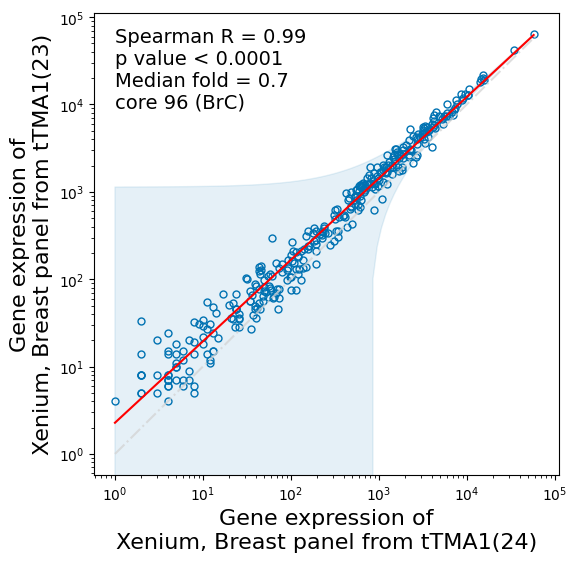

TypeError: argument of type 'bool' is not iterable

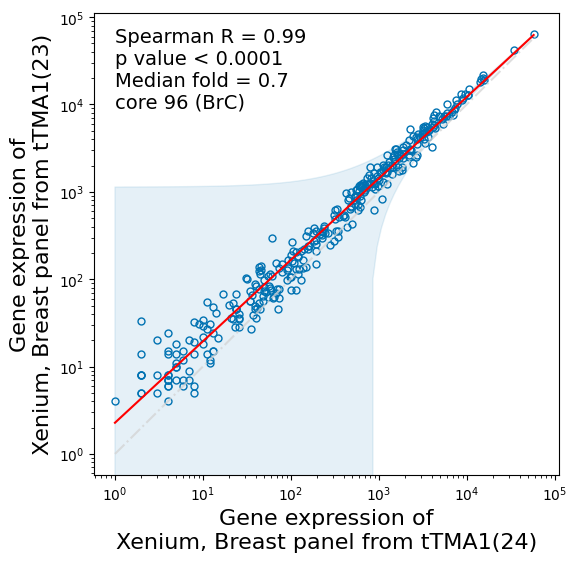

In [13]:
if not os.path.exists(f'{wd}/figures/Fig_1'):
    os.makedirs(f'{wd}/figures/Fig_1')

fontsize=16
Log_transform_method = 'non'

rs = []
cores = []
core_ps = []
median_folds = []
log2fcs = []

for count, sample_pair in enumerate([
    ['2024_xenium_breast_htma','xenium_breast_htma'],
    ['2024_cosmx_multitissue_htma','cosmx_multitissue_htma'],
    ['2024_merscope_breast_htma','merscope_breast_htma']
    ]):
    
    color_index = count + 1
    print (sample_pair)
    metric = f'count'
    df_m = {}

    sps = []
    for sample in sample_pair:

        df_t = pd.read_csv(f'{wd}/data/gene_level_csv/gene_level_csv_{sample}.csv')
        df_t = correct_tissue_names(sample, df_t)
        df_t['core'] += (300 if 'tumor2' in sample else 0) + (200 if 'normal' in sample else 0)
        df_sample = df_t[['gene','tissue_type','count','core']]
        
        tma =  name_parser(sample)['tma']
        tma_name = convert_tma_name_dict[tma.upper()]
        sample = sample.replace(tma,tma_name)
        sample = trim_name(sample, tma_name)
        sample = convert_sample_name(sample)

        df_sample = df_sample.rename(columns={'count':f'{sample}'})
        df_m[sample] = df_sample

        sps.append(sample)


    sample_1 = sps[0]
    sample_2 = sps[1]


    if color_index == 1:
        lims = [10**0, 10**6.2]
    elif color_index == 2:
        lims = [10**0, 10**6.5]
    elif color_index == 3:
        lims = [10**0, 10**5.5]


    df_sample_pair = pd.merge(df_m[sample_1], df_m[sample_2], on=['core','gene','tissue_type'], how='inner')
    df_sample_pair['fold'] = df_sample_pair.apply(lambda row: row[sample_1] /row[sample_2], axis=1)
    df_sample_pair['log2fc'] = df_sample_pair.apply(lambda row: log2_fold_change(row[sample_1], row[sample_2]), axis=1)

    # df_sample_pair = log_transform(df_sample_pair, method=Log_transform_method, exclude_cols=['core','fold','log2fc'])

    for core in df_sample_pair.core.unique():
        df_core_plot = df_sample_pair.loc[df_sample_pair['core']==core]
        r, p = sp.stats.spearmanr(df_core_plot[sample_1], df_core_plot[sample_2])
        p = '< 0.0001' if p < 0.0001 else round(p, 7)
        m_fold = round(df_core_plot['fold'].median(), 2)
    
        if m_fold < 0.05:
            m_fold = round(m_fold, 2)
        else:
            m_fold = round(m_fold, 1)

        log2fc = round(df_core_plot['log2fc'].median(), 2)

        # # Calculate the perpendicular distances - depreciated
        # df_core_plot['distance'] = np.abs(df_core_plot[sample_1] - df_core_plot[sample_2]) / np.sqrt(2)
        # mean_distance = df_core_plot['distance'].mean()

        if core in [96]:

                x_col = sample_1
                y_col = sample_2
                print(x_col, y_col)

                df_pair = df_core_plot[['gene', x_col, y_col]]
                df_pair = df_pair.reset_index(drop=True).dropna()
                df_pair['fold'] = df_pair.apply(lambda row: row[x_col] / row[y_col], axis=1)

                x_label = f"Gene expression of\n{x_col}"
                y_label = f"Gene expression of\n{y_col}"
                figure_name = f"{wd}/figures/Fig_1/supp_1_Core_{core}_{sample_1.split(f'_{tma_name}')[0]}_reproducibility"
                cus_anno=f"\ncore {core} (BrC)"
                marker_color=list(CB_COLORS_5.values())[color_index]
                
                r_new, p, residuals = gene_by_gene_plot(
                    df_pair,
                    x_col,
                    y_col,
                    marker_color,
                    x_label,
                    y_label,
                    tmas,
                    year,
                    figure_name=figure_name,
                    cus_anno=cus_anno,
                    fontsize=fontsize,
                    marker_size=5,
                )


                                
                r_new, p, residuals = gene_by_gene_plot(
                    df_pair,
                    x_col,
                    y_col,
                    marker_color,
                    x_label,
                    y_label,
                    tmas,
                    year,
                    figure_name=f"{wd}/figures/Fig_1/supp_1_Core_{core}_{sample_1.split(f'_{tma_name}')[0]}_reproducibility_with_gene_label",
                    cus_anno=cus_anno,
                    label_genes=True,
                    fontsize=fontsize,
                    marker_size=5,
                )


        rs.append(round(r,3))
        core_ps.append(f'{sample_1} vs. {sample_2}')
        cores.append(str(core))
        median_folds.append(m_fold)
        log2fcs.append(log2fc)


# Summarize results

In [9]:
# Select cores that have matching morphology
df_stats = pd.DataFrame({'pair':core_ps, 'core':cores, 'r':rs, 'median_fold':median_folds, 'log2fc':log2fcs})
df_stats['platform'] = df_stats['pair'].apply(lambda x: x.split(',')[0])
df_stats['core'] = df_stats['core'].astype(int)

filtered_df = df_stats.loc[
    ((df_stats['platform'] == 'Xenium') & (df_stats['core'].isin(xenium_breast_htma_matching_cores))) |
    ((df_stats['platform'] == 'MERSCOPE') & (df_stats['core'].isin(merscope_breast_htma_matching_cores))) |
    ((df_stats['platform'] == 'CosMx') & (df_stats['core'].isin(cosmx_multitissue_htma_matching_cores)))
]

display(filtered_df.head())

title_text_dict = {'r':'Spearman R',
                   'median_fold':'Median fold',
                   'log2fc':'Log2 fold change',
                   }

for metric in ['r','median_fold', 'log2fc']:

    # Assuming df_new is your DataFrame and it's already defined
    fig = go.Figure()

    width=500
    height=500
    fontsize = 16

    # Extract unique platforms to plot each as a separate box
    platforms = filtered_df['platform'].unique()
    for platform in platforms:
        data = filtered_df[filtered_df['platform'] == platform][metric]
        fig.add_trace(go.Box(
            y=data,
            name=platform,
            boxpoints='all',  # add all points
            jitter=0.3,  # adjust jitter to spread points horizontally
            pointpos=0,  # adjust position relative to the box (-2 to 2)
            marker_color=sample_color[platform.lower()]
        ))

    # Set box plot settings
    fig.update_traces(quartilemethod="exclusive")

    # Customize axes and layout
    fig.update_xaxes(title_text="", tickfont=dict(size=fontsize+2), showline=True, linewidth=2, linecolor='black')
    fig.update_yaxes(title_text=title_text_dict[metric], title_font=dict(size=fontsize+2), showline=True, linewidth=2, linecolor='black')
    fig.update_layout(
        width=width,
        height=height,
        title_text=f"Core level gene-by-gene<br>{title_text_dict[metric]} 2024 vs.2023",
        showlegend=False,
        title_font=dict(size=fontsize+2),
        legend_font=dict(size=fontsize),
        title_x=0.5,
        title_y=0.85,
        legend=dict(
            orientation="h",
            yanchor="bottom", 
            y=1.1,
            xanchor="center",
            x=0.5
        ),
        font=dict(color='black'),
        plot_bgcolor='rgba(0, 0, 0, 0)',  # Transparent plot background
        paper_bgcolor='rgba(0, 0, 0, 0)'  # Transparent paper background
    )

    # Show the plot
    fig.show()
    pio.write_image(fig, f'{wd}/figures/Fig_1/supp_1_core_reproducibility_{metric}_2024.png',scale=6, width=width, height=height)
    pio.write_image(fig, f'{wd}/figures/Fig_1/supp_1_core_reproducibility_{metric}_2024.eps',scale=4, width=width, height=height)


,pair,core,r,median_fold,log2fc,platform
5,"Xenium, Breast panel from tTMA1(24) vs. Xenium...",103,0.971,0.5,-0.99,Xenium
6,"Xenium, Breast panel from tTMA1(24) vs. Xenium...",104,0.981,1.1,0.19,Xenium
7,"Xenium, Breast panel from tTMA1(24) vs. Xenium...",105,0.991,0.9,-0.22,Xenium
8,"Xenium, Breast panel from tTMA1(24) vs. Xenium...",106,0.993,0.8,-0.26,Xenium
11,"Xenium, Breast panel from tTMA1(24) vs. Xenium...",109,0.970,0.8,-0.35,Xenium


# Response letter Figure R1C2a

In [10]:
# # This is for response letter

# # plot_all = True


# if not os.path.exists(f'{wd}/figures/Fig_1'):
#     os.makedirs(f'{wd}/figures/Fig_1')

# fontsize=16
# Log_transform_method = 'non'

# rs = []
# cores = []
# core_ps = []
# median_folds = []
# log2fcs = []

# for count, sample_pair in enumerate([
#     ['xenium_breast_htma','xenium_lung_htma'],
#     ['xenium_breast_normal','xenium_lung_normal'],
#     ['merscope_breast_htma','merscope_lung_htma'],
#     ['merscope_breast_normal','merscope_lung_normal'],
#     ]):
    
#     color_index = count + 1
#     print (sample_pair)
#     metric = f'count'
#     df_m = {}

#     sps = []
#     for sample in sample_pair:

#         df_t = pd.read_csv(f'{wd}/data/gene_level_csv/gene_level_csv_{sample}.csv')
#         df_t = correct_tissue_names(sample, df_t)
#         df_t['core'] += (300 if 'tumor2' in sample else 0) + (200 if 'normal' in sample else 0)
#         df_sample = df_t[['gene','tissue_type','count','core']]
#         df_sample['gene_type'] = df_sample['gene'].apply(lambda x:get_gene_type(x))
#         df_sample = df_sample.loc[df_sample['gene_type']=='gene']

#         tma =  name_parser(sample)['tma'].upper()
#         tma_name = convert_tma_name_dict[tma]

#         sample = sample.replace(tma,tma_name)
#         sample = trim_name(sample, tma_name)
#         sample = convert_sample_name(sample)

#         df_sample = df_sample.rename(columns={'count':f'{sample}'})
#         df_m[sample] = df_sample

#         sps.append(sample)


#     sample_1 = sps[0]
#     sample_2 = sps[1]

#     if color_index == 1:
#         lims = [10**0, 10**6.2]
#     elif color_index == 2:
#         lims = [10**0, 10**6.5]
#     elif color_index == 3:
#         lims = [10**0, 10**5.5]


#     df_sample_pair = pd.merge(df_m[sample_1], df_m[sample_2], on=['core','gene','tissue_type'], how='inner')
#     df_sample_pair['fold'] = df_sample_pair.apply(lambda row: row[sample_1] /row[sample_2], axis=1)
#     df_sample_pair['log2fc'] = df_sample_pair.apply(lambda row: log2_fold_change(row[sample_1], row[sample_2]), axis=1)
#     # df_sample_pair = log_transform(df_sample_pair, method=Log_transform_method, exclude_cols=['core','fold','log2fc'])

#     for core in df_sample_pair.core.unique():
#         df_core_plot = df_sample_pair.loc[df_sample_pair['core']==core]
        
#         r, p = sp.stats.spearmanr(
#             np.log10(df_core_plot[sample_1].replace(0, np.nan)).dropna(),
#             np.log10(df_core_plot[sample_2].replace(0, np.nan)).dropna(),
#             )

#         p = '< 0.0001' if p < 0.0001 else round(p, 7)
#         m_fold = round(df_core_plot['fold'].median(), 2)
    
#         if m_fold < 0.05:
#             m_fold = round(m_fold, 2)
#         else:
#             m_fold = round(m_fold, 1)

#         log2fc = round(df_core_plot['log2fc'].median(), 2)

#         # # Calculate the perpendicular distances - depreciated
#         # df_core_plot['distance'] = np.abs(df_core_plot[sample_1] - df_core_plot[sample_2]) / np.sqrt(2)
#         # mean_distance = df_core_plot['distance'].mean()

#         if core >0:
#             if core in [48, 103, 105, 109, 110, 113, 114, 115, 117, 118, 124, 203, 66, 24, 212,239]:
#             # if r > 0.95:
    
#                 x_col = sample_1
#                 y_col = sample_2
#                 print(x_col, y_col)

#                 df_pair = df_core_plot[['gene', x_col, y_col]]
#                 df_pair = df_pair.reset_index(drop=True).dropna()
#                 df_pair['fold'] = df_pair.apply(lambda row: row[x_col] / row[y_col], axis=1)

#                 x_label = f"Gene expression of\nXenium Breast panel from {tma_name}"
#                 y_label = f"Gene expression of\nXenium Lung panel from {tma_name}"
#                 figure_name = f"{wd}/figures/response_letter/sample_morphology_dependency_{sample_pair[0]}_vs_{sample_pair[1]}_{core}"
#                 cus_anno=f"\nCore: {core}"
#                 marker_color=list(CB_COLORS_5.values())[color_index]
                
#                 r_new, p, residuals = gene_by_gene_plot(
#                     df_pair,
#                     x_col,
#                     y_col,
#                     marker_color,
#                     x_label,
#                     y_label,
#                     tmas,
#                     year,
#                     figure_name=figure_name,
#                     cus_anno=cus_anno,
#                     label_genes=True,
#                     fontsize=fontsize,
#                     marker_size=5,
#                 )

#         rs.append(round(r,3))
#         core_ps.append(f'{sample_1} vs. {sample_2}')
#         cores.append(str(core))
#         median_folds.append(m_fold)
#         log2fcs.append(log2fc)


In [14]:

selected_genes = {
    0:['GZMK', 'TCL1A', 'PDCD1', 'KART7', 'EPCAM', 'CD79A', 'TDCSTD2', 'NKG7', 'MMP12', 'KLRC1', 'CDH1'],
    1:["TNFRSF17", "PDCD1", "AGR3", "HMGA1", "LAG3", "CD14", "GZMK", "HMGA1", "ANKRD28", "CD79B", "MS4A1",],
}

selected_cores = {
    1: [38, 110, 41, 71, 155, 99, 144, 96, 91, 143, 42, 106, 92, 112, 108, 43, 60, 156, 135, 157],
    0: [148, 135, 132, 8, 95, 92, 155, 15, 22, 17, 154, 130, 134, 16, 138, 143, 136, 125, 128, 149]
}


['xenium_breast_htma', 'xenium_lung_htma']
Xenium, Breast panel from htma Xenium, Lung panel from htma


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


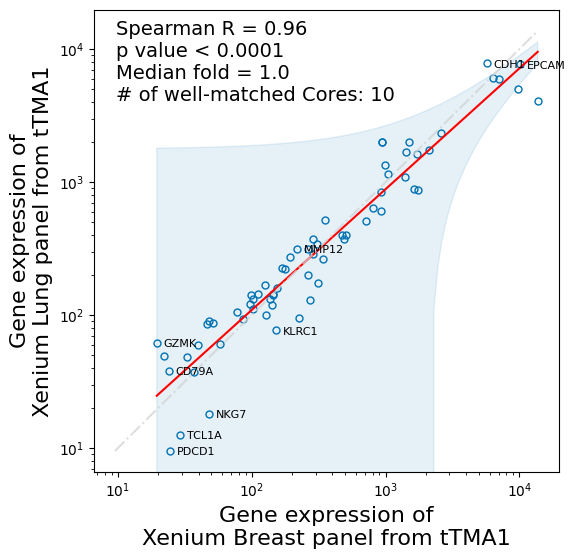

['merscope_breast_htma_round1', 'merscope_lung_htma']
MERSCOPE, Breast panel from htma from round1 MERSCOPE, Lung panel from htma


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


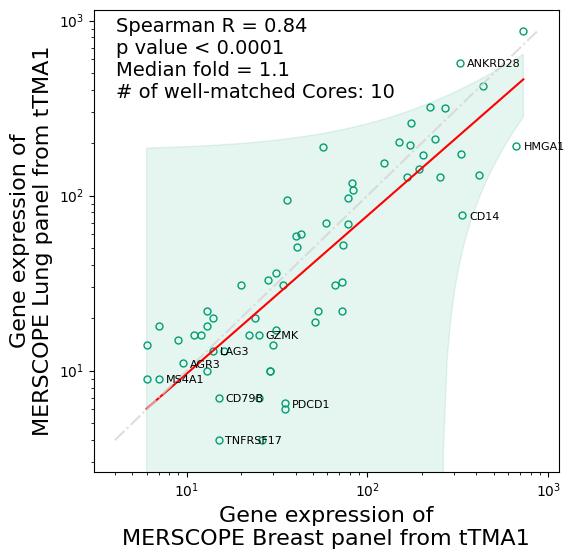

In [15]:
# This is for response letter

# plot_all = True


top_num_cores = 10

if not os.path.exists(f'{wd}/figures/Fig_1'):
    os.makedirs(f'{wd}/figures/Fig_1')

fontsize=16
Log_transform_method = 'non'

rs = []
cores = []
core_ps = []
median_folds = []
log2fcs = []

for count, sample_pair in enumerate([
    ['xenium_breast_htma','xenium_lung_htma'],
    ['merscope_breast_htma_round1','merscope_lung_htma'],
    ]):
    
    color_index = count + 1
    print (sample_pair)
    metric = f'count'
    df_m = {}

    sps = []
    for sample in sample_pair:

        df_t = pd.read_csv(f'{wd}/data/gene_level_csv/gene_level_csv_{sample}.csv')
        df_t = correct_tissue_names(sample, df_t)
        df_t['core'] += (300 if 'tumor2' in sample else 0) + (200 if 'normal' in sample else 0)
        df_sample = df_t[['gene','tissue_type','count','core']]
        df_sample['gene_type'] = df_sample['gene'].apply(lambda x:get_gene_type(x))
        df_sample = df_sample.loc[df_sample['gene_type']=='gene']
        df_sample = df_sample.drop(columns=['gene_type', 'tissue_type'])

        tma =  name_parser(sample)['tma'].upper()
        tma_name = convert_tma_name_dict[tma]

        sample = sample.replace(tma,tma_name)
        sample = trim_name(sample, tma_name)
        sample = convert_sample_name(sample)

        df_sample = df_sample.rename(columns={'count':f'{sample}'})
        df_m[sample] = df_sample

        sps.append(sample)


    sample_1 = sps[0]
    sample_2 = sps[1]

    if color_index == 1:
        lims = [10**0, 10**6.2]
    elif color_index == 2:
        lims = [10**0, 10**6.5]
    elif color_index == 3:
        lims = [10**0, 10**5.5]


    df_sample_pair = pd.merge(df_m[sample_1], df_m[sample_2], on=['core','gene'], how='inner')
    df_sample_pair['fold'] = df_sample_pair.apply(lambda row: row[sample_1] /row[sample_2], axis=1)
    df_sample_pair['log2fc'] = df_sample_pair.apply(lambda row: log2_fold_change(row[sample_1], row[sample_2]), axis=1)
    # df_sample_pair = log_transform(df_sample_pair, method=Log_transform_method, exclude_cols=['core','fold','log2fc'])


    df_core_plot = df_sample_pair.loc[df_sample_pair['core'].isin(selected_cores[count][:top_num_cores])]

    df_core_plot_gr = df_core_plot.groupby(by=['gene']).median().reset_index()
    
    r, p = sp.stats.spearmanr(
        np.log10(df_core_plot_gr[sample_1].replace(0, np.nan)).dropna(),
        np.log10(df_core_plot_gr[sample_2].replace(0, np.nan)).dropna(),
        )

    p = '< 0.0001' if p < 0.0001 else round(p, 7)
    m_fold = round(df_core_plot_gr['fold'].median(), 2)

    if m_fold < 0.05:
        m_fold = round(m_fold, 2)
    else:
        m_fold = round(m_fold, 1)

    x_col = sample_1
    y_col = sample_2
    print(x_col, y_col)

    df_pair = df_core_plot_gr[['gene', x_col, y_col]]
    df_pair = df_pair.reset_index(drop=True).dropna()
    df_pair['fold'] = df_pair.apply(lambda row: row[x_col] / row[y_col], axis=1)

    x_label = f"Gene expression of\n{x_col.split(',')[0]} Breast panel from {tma_name}"
    y_label = f"Gene expression of\n{y_col.split(',')[0]} Lung panel from {tma_name}"
    figure_name = f"{wd}/figures/response_letter/sample_morphology_dependency_{sample_pair[0]}_vs_{sample_pair[1]}_multi_cores"
    cus_anno=f"\n# of well-matched Cores: {len(selected_cores[count][:top_num_cores])}"
    marker_color=list(CB_COLORS_5.values())[color_index]
    
    r_new, p, residuals = gene_by_gene_plot(
        df_pair,
        x_col,
        y_col,
        marker_color,
        x_label,
        y_label,
        tmas,
        year,
        figure_name=figure_name,
        cus_anno=cus_anno,
        label_genes=selected_genes[count],
        fontsize=fontsize,
        marker_size=5,
    )


